In [3]:
import os 

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 

import tifffile

In [4]:
# Path to the slices 
data_dir = 'D:\sagar\Data\MD_1264_A5_1_Z3.3mm_corr_phrt\slices'
tiffs = os.listdir(data_dir)

In [56]:
for t in tiffs:
    print(t)

slice_0000.tif
slice_0001.tif
slice_0002.tif
slice_0003.tif
slice_0004.tif
slice_0005.tif
slice_0006.tif
slice_0007.tif
slice_0008.tif
slice_0009.tif
slice_0010.tif
slice_0011.tif
slice_0012.tif
slice_0013.tif
slice_0014.tif
slice_0015.tif
slice_0016.tif
slice_0017.tif
slice_0018.tif
slice_0019.tif
slice_0020.tif
slice_0021.tif
slice_0022.tif
slice_0023.tif
slice_0024.tif
slice_0025.tif
slice_0026.tif
slice_0027.tif
slice_0028.tif
slice_0029.tif
slice_0030.tif
slice_0031.tif
slice_0032.tif
slice_0033.tif
slice_0034.tif
slice_0035.tif
slice_0036.tif
slice_0037.tif
slice_0038.tif
slice_0039.tif
slice_0040.tif
slice_0041.tif
slice_0042.tif
slice_0043.tif
slice_0044.tif
slice_0045.tif
slice_0046.tif
slice_0047.tif
slice_0048.tif
slice_0049.tif
slice_0050.tif
slice_0051.tif
slice_0052.tif
slice_0053.tif
slice_0054.tif
slice_0055.tif
slice_0056.tif
slice_0057.tif
slice_0058.tif
slice_0059.tif
slice_0060.tif
slice_0061.tif
slice_0062.tif
slice_0063.tif
slice_0064.tif
slice_0065.tif
slice_0066

In [6]:
# Reading all the slices in a Volume 
vol = np.empty(shape=(1700, 3707, 3707), dtype=np.float32)
for i, fname in enumerate(tqdm(tiffs)):
    im = Image.open(os.path.join(data_dir, fname))
    imarray = np.array(im)
    vol[i, :, :] = imarray

100%|██████████████████████████████████████████████████████████████████████████████| 1700/1700 [08:11<00:00,  3.46it/s]


In [4]:
# Reading all the slices in a Volume 
vol = []
for fname in tqdm(tiffs):
    im = Image.open(os.path.join(data_dir, fname))
    imarray = np.array(im)
    vol.append(imarray)

vol = np.asarray(vol)

100%|██████████████████████████████████████████████████████████████████████████████| 1700/1700 [07:58<00:00,  3.55it/s]


In [10]:
print(vol.shape)

(1700, 3707, 3707)


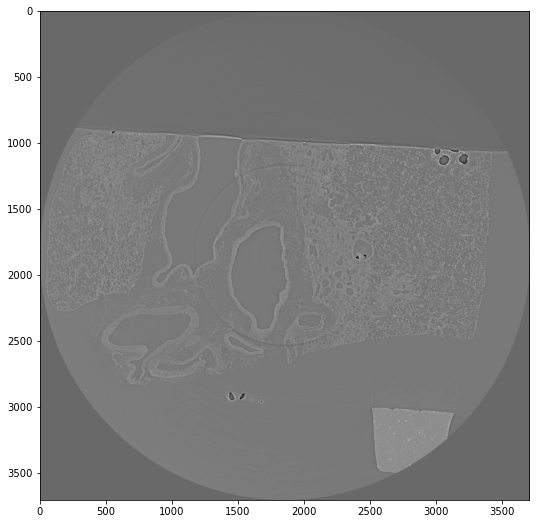

In [11]:
#Ploting the middle slice 
plt.figure(figsize=(16,9))
plt.imshow(vol[850, :, :], cmap='gray')
plt.show()

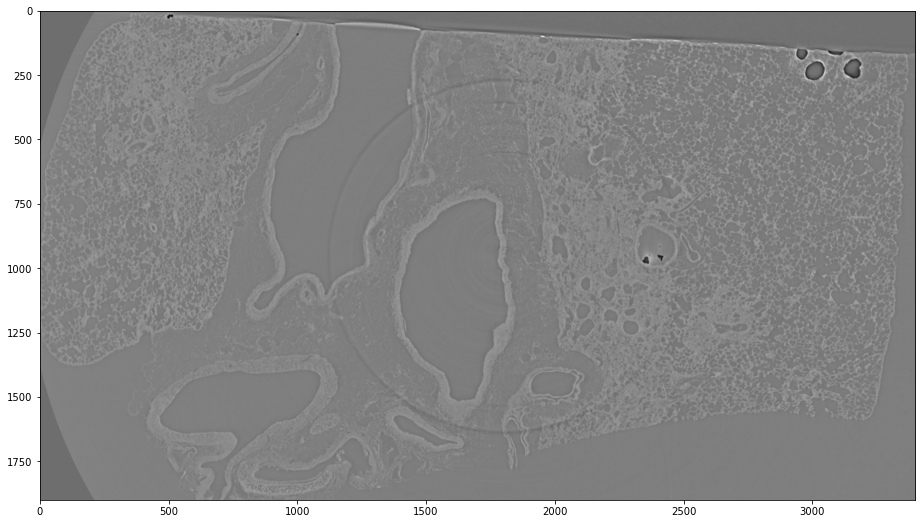

In [12]:
#Ploting the middle slice 
plt.figure(figsize=(16,9))
plt.imshow(vol[850, 900:3707-907, 50:3707-257], cmap='gray')
plt.show()

In [43]:
xdim = vol.shape[1]
ydim = vol.shape[2]
zdim = vol.shape[0]

# Offset for ROI volume
# Have to check manually for each data (Maybe)

rowStartingOffset = 900
rowEndingOffset = 907

colStartingOffset = 50
colEndingOffset = 257

roi_vol = vol[:, rowStartingOffset:xdim-rowEndingOffset, colStartingOffset:ydim-colEndingOffset]

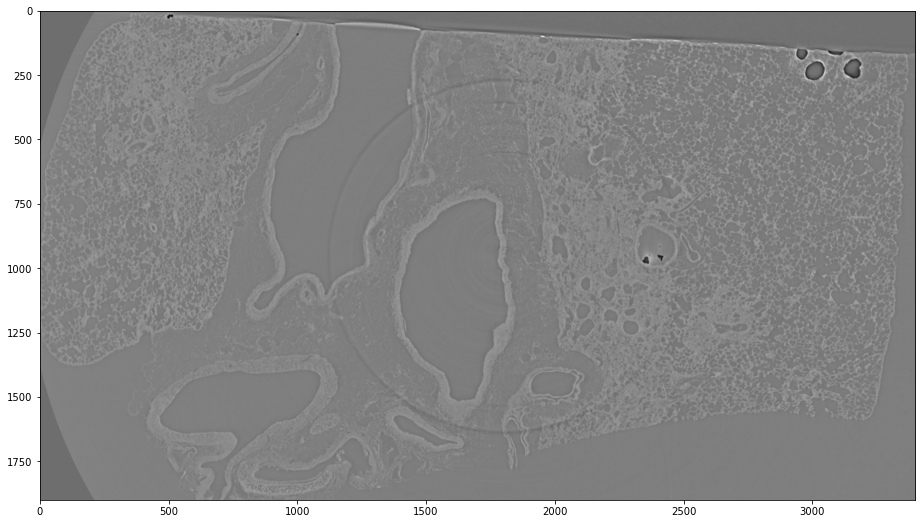

In [50]:
#Ploting the middle slice 
plt.figure(figsize=(16,9))
plt.imshow(roi_vol[850, :, :], cmap='gray')
plt.show()

In [45]:
roi_vol.shape

(1700, 1900, 3400)

In [46]:
# define the parameter for cliping the roi 

# size of 3D cube 
cube_size = 300
# step size in each direction
step_size = 200

In [51]:
# finding the range for the loop 
depth = roi_vol.shape[0]
row = roi_vol.shape[1]
col = roi_vol.shape[2]

In [52]:
print(list(range(0, row-cube_size, step_size)))
print(list(range(0, col-cube_size, step_size)))

[0, 200, 400, 600, 800, 1000, 1200, 1400]
[0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000]


In [53]:
del vol 

In [54]:
# function to save slices of a volume into a defined folder 

def saveSlices(volume, folderName):
    depth = volume.shape[0]
    for aSlice in range(depth):
        img = volume[aSlice, :, :]
        if not os.path.exists(folderName):
            os.makedirs(folderName)
        fName = os.path.join(folderName, f'slice_{aSlice}.tif') 
        tifffile.imsave(fName, img)

In [55]:
minmax = {}
all_roi = []
mins = []
maxs = []

depthList = list(range(0, depth, step_size))

for d in tqdm(depthList[:-1]):
    for r in range(0, row-cube_size, step_size):
        for c in range(0, col-cube_size, step_size):
            cube = roi_vol[d:d+cube_size, r:r+cube_size, c:c+cube_size]
            
            roiName = f'{d}-{d+cube_size}x{rowStartingOffset+r}-{rowStartingOffset+r+cube_size}x{colStartingOffset+c}-{colStartingOffset+c+cube_size}'
            all_roi.append(roiName)
            mins.append(cube.min())
            maxs.append(cube.max())
            
            
            #fileName = f'{os.path.dirname(data_dir)}\\tiles\\{d}-{d+cube_size}x{rowStartingOffset+r}-{rowStartingOffset+r+cube_size}x{colStartingOffset+c}-{colStartingOffset+c+cube_size}.raw'
            #cube.tofile(fileName)
            
            pathName = f'{os.path.dirname(data_dir)}\\tiles\\{d}-{d+cube_size}x{rowStartingOffset+r}-{rowStartingOffset+r+cube_size}x{colStartingOffset+c}-{colStartingOffset+c+cube_size}'
            saveSlices(cube, pathName)
            

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [06:36<00:00, 49.59s/it]


In [114]:
minList = []
for i in range(len(mins)):
    minList.append(mins[i].tolist())
    
maxList = []
for i in range(len(maxs)):
    maxList.append(maxs[i].tolist())

In [115]:
minmax = {}
minmax['roi'] = all_roi
minmax['min'] = minList
minmax['max'] = maxList

In [116]:
import json
jsonString = json.dumps(minmax)
jsonFile = open(data_dir.split('slices')[0] + 'tiles.json', "w")
jsonFile.write(jsonString)
jsonFile.close()